### Solver API scratchbook

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import time

from nuMSM_solver.solvers import *
from nuMSM_solver.quadrature import GaussianQuadrature
from nuMSM_solver.rates import Rates_Jurai

In [2]:
# Optimal phases
delta_opt = np.pi
eta_opt = (3.0*np.pi)/2.0
rew_opt = np.pi/4.0

# Model params
mp = ModelParams(M=1.0, dM=1e-11, Imw=3, Rew=rew_opt, delta=delta_opt, eta=eta_opt)

# Metaparams
H = 1
ode_pars = {'atol': 1e-20, 'rtol': 1e-4}

In [3]:
# Set up quadrature scheme and rates
n_kc = 5
kc_max = 10

#TODO factor out rates from quadrature class, no idea why I did it like that

# Hide annoying warning
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    quad = GaussianQuadrature(n_kc, 0, kc_max, mp, H, qscheme="legendre")
    rates = Rates_Jurai(mp, H, quad.kc_list(), tot=False)

In [4]:
# Solve equations with QuadratureSolver
solver = QuadratureSolver(rates, quad,
                         model_params=mp, TF=Tsph, H=H, fixed_cutoff=1e-5, eig_cutoff=False,
                         method="Radau", ode_pars=ode_pars, source_term=True)

start = time.time()
solver.solve()
end = time.time()
bau = (28./79.) * solver.get_final_lepton_asymmetry()
print("Time (solve): {}, BAU = {}".format(end - start, bau))

/home/admin/SciCodes/leptogenesis-tools/leptotools/momentumDep.py:49: RuntimeWarning: divide by zero encountered in log
  lgM = np.log(gammaMFromQm(M, kT_ax, T_ax, Qm_Tot) / T_ax)[argK]
/home/admin/SciCodes/leptogenesis-tools/leptotools/momentumDep.py:49: RuntimeWarning: invalid value encountered in log
  lgM = np.log(gammaMFromQm(M, kT_ax, T_ax, Qm_Tot) / T_ax)[argK]


Time (solve): 2.6146464347839355, BAU = -1.7007407071300652e-10


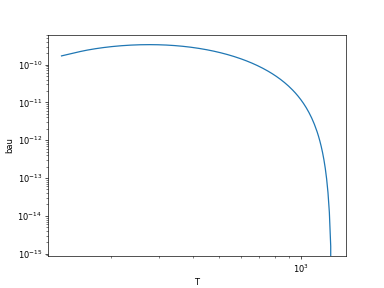

In [5]:
# Plot BAU generation
fig = plt.figure(dpi=60)
ax = fig.add_subplot(111)
plt.xlabel("T")
plt.ylabel("bau")
plt.xscale("log")
plt.yscale("log")
plt.plot(solver.get_Tlist(), (28./79.) * np.abs(np.array(solver.get_total_lepton_asymmetry())))